### Make plots from reco dataframe

In [1]:
import pickle
import math

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

In [2]:
with open('/home/atfienberg/freedomDataCopy/public_for_aaron/test_events.pkl', 'rb') as f:
    events = pickle.load(f)

In [3]:
chargenet_df = pd.read_pickle('/home/atfienberg/IceCube/freeDOM/examples/reco/'
                    'chargenet_reco_08_31_2020-20_04_24.pkl')

domnet_df = pd.read_pickle('/home/atfienberg/IceCube/freeDOM/examples/reco/'
                           'domnet_reco_08_31_2020-20_55_58.pkl')

dfs = domnet_df, chargenet_df
labels = 'DOMnet', 'chargenet', 'Retro'

# df = pd.read_pickle('fit_results_8_7_2020.pkl')

In [4]:
print('Nets used for this reconstruction comparison:\n')
for df, name in zip(dfs, ['DOMnet', 'chargenet']):
    print(f'{name}:')
    for key, value in df.attrs['reco_conf']['service_conf'].items():
        if key.endswith('file'):
            print(f'{value}')
    print('\n')

Nets used for this reconstruction comparison:

DOMnet:
/home/atfienberg/freedomDataCopy/public_for_aaron/HitNet_ranger_30_Jul_2020-15h49/epoch_32_model.hdf5
/home/atfienberg/freedomDataCopy/public_for_aaron/DOMNet_reduced_22_Jul_2020-15h18/epoch_30_model.hdf5


chargenet:
/home/atfienberg/freedomDataCopy/public_for_aaron/HitNet_ranger_14_Jul_2020-08h03/epoch_32_model.hdf5
ChargeNet_nChannels_22_May_2020-11h05/epoch_400_model.hdf5




In [5]:
# # select events where we found an LLH about as good as the true parameters or better
# good_inds = np.full(len(chargenet_df), 1, np.bool)
# for df in dfs:
#     good_inds = good_inds & (df.free_fit_llh < df.true_p_llh) & (df.free_fit_llh < 1e8) 
# print(f'good frac: {np.count_nonzero(good_inds)/len(df):.2f}')

# use all for these plots; no cheating
good_inds = np.full(len(chargenet_df), 1, np.bool)

good_dfs = [df[good_inds] for df in dfs]

In [6]:
par_names = ['x', 'y', 'z', 'time',
             'azimuth', 'zenith', 
             'cascade energy', 'track energy']

# grab true parameters and retro parameters
true_ps = np.empty((len(events), 8), dtype=np.float32)
retro_ps = np.empty_like(true_ps)
for i, event in enumerate(events):
    true_ps[i, :] = event['params']
    retro_ps[i, :] = event['retro']

true_df = pd.DataFrame(true_ps, columns=par_names)
retro_df = pd.DataFrame(retro_ps, columns=par_names)

In [7]:
good_retro = retro_df[good_inds]
good_true = true_df[good_inds]

In [8]:
# retro_zen_diff = good_retro[:, 5] - good_true[:, 5]
# spe_zen_diff = good_spe[:, 5] - good_true[:, 5] 
# freedom_zen_diffs = [good_df.zenith - good_true[:, 5] for good_df in good_dfs]

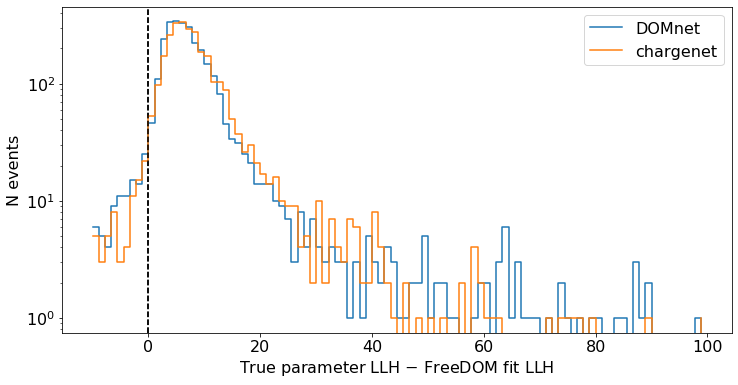

In [9]:
fig, ax = plt.subplots(1, 1, figsize=(12, 6))

bins = np.linspace(-10, 100, 100)
for good_df, label in zip(good_dfs, labels):
    llh_diff = good_df.true_p_llh - good_df.free_fit_llh
    hist, bins = np.histogram(llh_diff, bins)
    ax.step(bins[:-1], hist, where='post', label=label)
    ax.axvline(0, linestyle='--', color='black')
    ax.set_xlabel('True parameter LLH $-$ FreeDOM fit LLH', fontsize=16)
    ax.set_ylabel('N events', fontsize=16)
    ax.tick_params(labelsize=16)
    ax.set_yscale('log')

ax.legend(fontsize=16)

In [10]:
def get_quantiles(vals, quantiles=[0.25, 0.5, 0.75]):
    vals = np.sort(vals)
    
    quant_vals = [vals[int(quant*len(vals))] for quant in quantiles]
    
    return quant_vals

In [11]:
color_cycle = plt.rcParams['axes.prop_cycle'].by_key()['color']

In [12]:
def plot_quants(quants, ax, color, style='--', dashes=None):
    if dashes is not None:
        ax.axvline(quants[0], color=color, linestyle=style, linewidth=2, dashes=dashes)
        ax.axvline(quants[1], color=color, linestyle='-', linewidth=2)    
        ax.axvline(quants[2], color=color, linestyle=style, linewidth=2, dashes=dashes)    
    else:
        ax.axvline(quants[0], color=color, linestyle=style, linewidth=2)
        ax.axvline(quants[1], color=color, linestyle='-', linewidth=2)    
        ax.axvline(quants[2], color=color, linestyle=style, linewidth=2)    

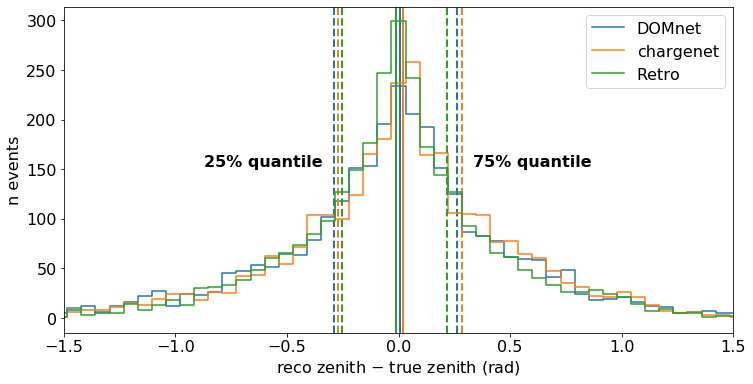

In [13]:
fig, ax = plt.subplots(1, 1, figsize=(12, 6))
bins = np.linspace(-2*math.pi, 2*math.pi, 200)
# retro_hist, bins = np.histogram(retro_zen_diff, bins=bins)
# freedom_hist, bins = np.histogram(freedom_zen_diff, bins=bins)
# spe_hist, bins = np.histogram(spe_zen_diff, bins=bins,)

quants_list = []
for df, label in zip(good_dfs + [good_retro], labels):
    zen_diff = df['zenith'] - good_true['zenith']
    zen_hist, _ = np.histogram(zen_diff, bins=bins)
    ls = ax.step(bins[:-1], zen_hist, where='post', label=label)
    
    quants = get_quantiles(zen_diff)
    quants_list.append(quants)
    plot_quants(quants, ax, ls[0].get_color())

lowest = min(q[0] for q in quants_list)
highest = max(q[-1] for q in quants_list)

ax.text(lowest-0.05, 150, '25% quantile', 
        horizontalalignment='right', 
        verticalalignment='bottom',
        fontdict={'fontsize': 16, 'fontweight': 'bold'})

ax.text(highest+0.05, 150, '75% quantile', 
        horizontalalignment='left',
        verticalalignment='bottom',
        fontdict={'fontsize': 16, 'fontweight': 'bold'})

ax.set_xlim(-1.5, 1.5)

ax.set_xlabel('reco zenith $-$ true zenith (rad)', fontsize=16)
ax.set_ylabel('n events', fontsize=16)
ax.tick_params(labelsize=16)

ax.legend(fontsize=16)

# plot_name='pres_plots/zenith_reco_domnet_quantiles.pdf'
# fig.savefig(plot_name, bbox='tight')

In [14]:
def make_diff_plot(par_name, logy=False):
    ind = par_names.index(par_name)
    
    diffs = [df[par_name] - good_true[par_name] for df in good_dfs + [retro_df]]
    
    fig, ax = plt.subplots(1, 1, figsize=(12, 6))
    if not par_name.endswith('energy'):
        bins = np.linspace(diffs[0].mean() - 2.5*diffs[0].std(), 
                           diffs[0].mean() + 2.5*diffs[0].std(), 100)
    else:
        bins = np.linspace(-500, 100, 100)
    
    for diff, label in zip(diffs, labels):
        hist, bins = np.histogram(diff, bins)
        ax.step(bins[:-1], hist, where='post', label=label)

    ax.set_xlabel(f'reco {par_name} $-$ true {par_name}', fontsize=16)
    ax.set_ylabel('n events', fontsize=16)
    ax.tick_params(labelsize=16)

    if logy:
        ax.set_yscale('log')
    
    ax.legend(fontsize=16)

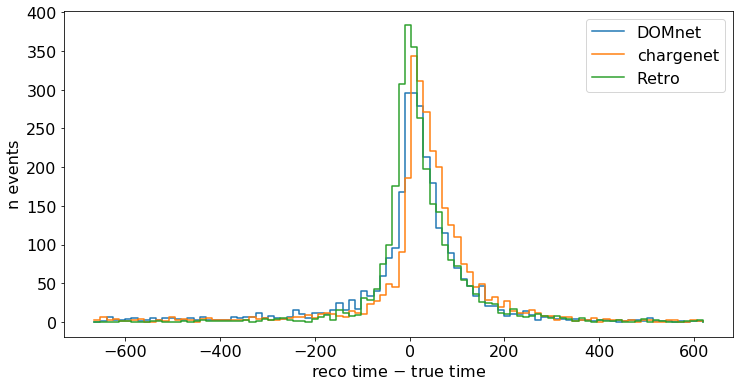

In [15]:
make_diff_plot('time', False)

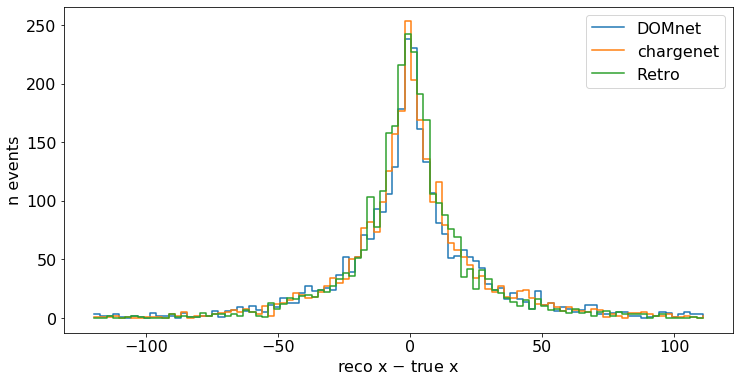

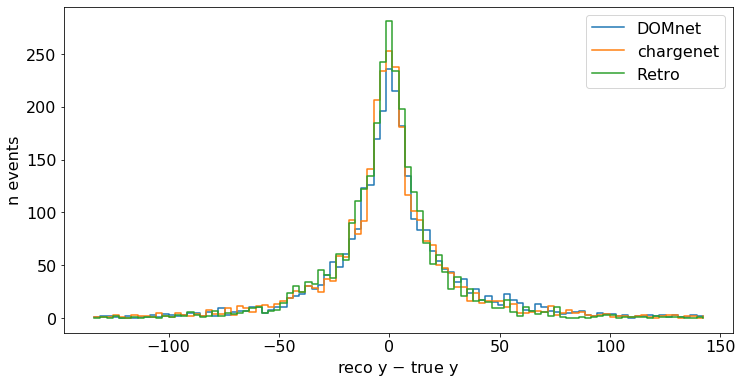

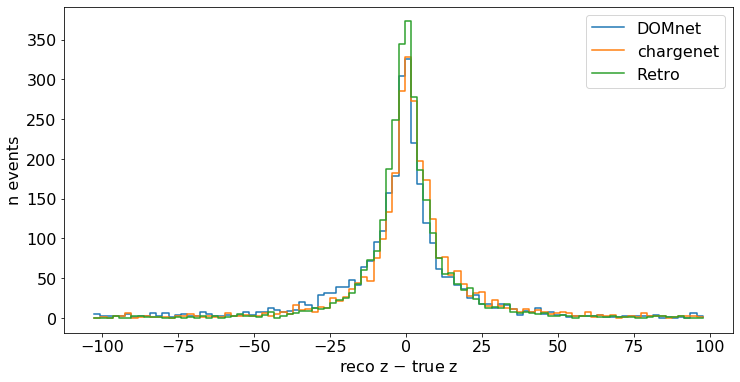

In [16]:
for par in ['x', 'y', 'z']:
    make_diff_plot(par, False)

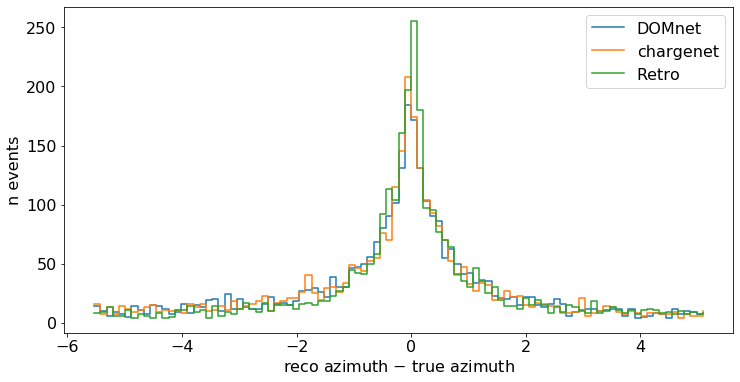

In [17]:
make_diff_plot('azimuth', False)

### energy plots 
I removed the 2d energy plots for now in favor of the binned hists. Look back at old reco notebook if you want the code to make those 2d plots

In [18]:
all_dfs = good_dfs + [good_retro, good_true]

for df in all_dfs:
    df['e_tot'] = df['cascade energy'] + df['track energy']

# clip true & retroenergies before taking ratios and logs later on
for par in par_names[-2:]:
    for df in all_dfs[-2:]:
        df[par] = np.clip(df[par], 0.001, 10000)

for df in all_dfs[:-1]:
    df['log_e_diff'] = np.log10(df['e_tot']) - np.log10(good_true['e_tot'])
    df['e_rat'] = (df['e_tot'] - good_true['e_tot'])/good_true['e_tot']

Text(0, 0.5, 'n events')

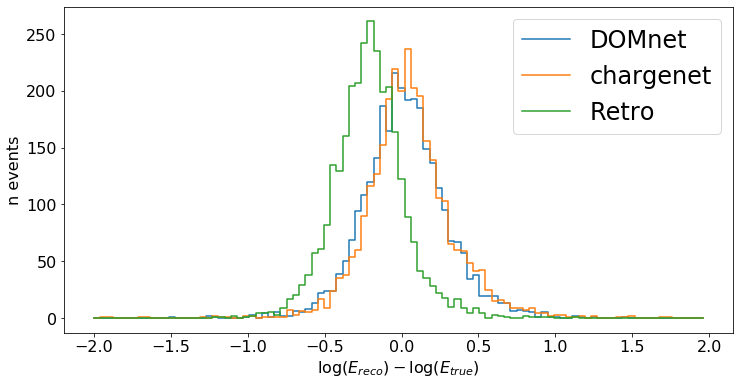

In [19]:
fig, ax = plt.subplots(1, 1, figsize=(12, 6))
hist_bins = np.linspace(-2, 2, 100)

for df, label in zip(all_dfs[:-1], labels):
    hist, bins = np.histogram(df['log_e_diff'], hist_bins)
    
    ax.step(bins[:-1], hist, where='post', label=label)
    
ax.legend(fontsize=24)
ax.tick_params(labelsize=16)
ax.set_xlabel('$\log(E_{reco}) - \log(E_{true})$', fontsize=16)
ax.set_ylabel('n events', fontsize=16)

Text(0, 0.5, 'n events')

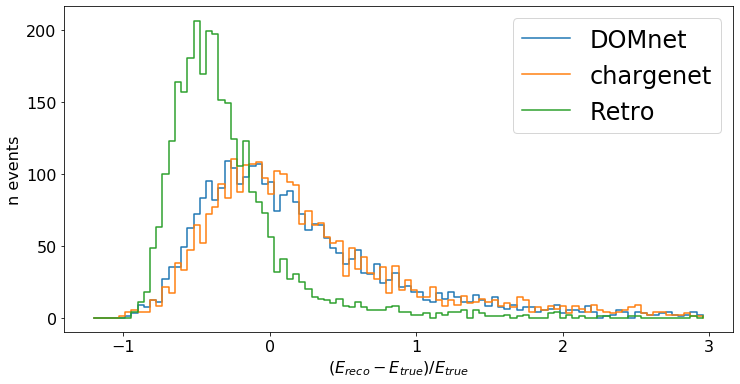

In [20]:
fig, ax = plt.subplots(1, 1, figsize=(12, 6))
hist_bins = np.linspace(-1.2, 3, 100)

for df, label in zip(all_dfs[:-1], labels):
    hist, bins = np.histogram(df['e_rat'], hist_bins)
        
    ax.step(bins[:-1], hist, where='post', label=label)
    
ax.legend(fontsize=24)
ax.tick_params(labelsize=16)
ax.set_xlabel('$(E_{reco} - E_{true}) / E_{true}$', fontsize=16)
ax.set_ylabel('n events', fontsize=16)

# Remake the above plot after unbiasing the retro energies (via multiplicative scaling)
# set the median to 0

In [21]:
for df in all_dfs[:-1]:
    median = get_quantiles(df['e_rat'])[1]
    df['cor_e_tot'] = df['e_tot']/(1+median)
    
for df in all_dfs[:-1]:
    df['cor_log_e_diff'] = np.log10(df['cor_e_tot']) - np.log10(good_true['e_tot'])
    df['cor_e_rat'] = (df['cor_e_tot'] - good_true['e_tot'])/good_true['e_tot']

Text(0, 0.5, 'n events')

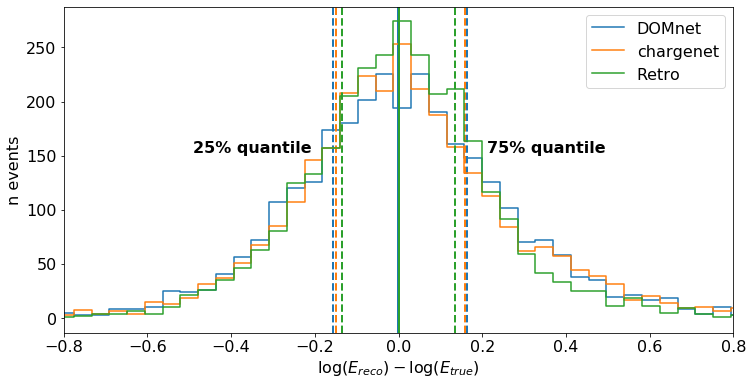

In [22]:
fig, ax = plt.subplots(1, 1, figsize=(12, 6))
hist_bins = np.linspace(-2, 2, 150)

quants_list = []
for df, label in zip(good_dfs + [good_retro], labels):
    hist, _ = np.histogram(df['cor_log_e_diff'], bins=bins)
    ls = ax.step(bins[:-1], hist, where='post', label=label)
    
    quants = get_quantiles(df['cor_log_e_diff'])
    quants_list.append(quants)
    plot_quants(quants, ax, ls[0].get_color())

lowest = min(q[0] for q in quants_list)
highest = max(q[-1] for q in quants_list)
ax.text(lowest-0.05, 150, '25% quantile', 
        horizontalalignment='right', 
        verticalalignment='bottom',
        fontdict={'fontsize': 16, 'fontweight': 'bold'})
ax.text(highest+0.05, 150, '75% quantile', 
        horizontalalignment='left',
        verticalalignment='bottom',
        fontdict={'fontsize': 16, 'fontweight': 'bold'})

    
ax.set_xlim(-0.8, 0.8)
ax.legend(fontsize=16, loc='upper right')
ax.tick_params(labelsize=16)
ax.set_xlabel('$\log(E_{reco}) - \log(E_{true})$', fontsize=16)
ax.set_ylabel('n events', fontsize=16)

# plot_name='pres_plots/energy_reco_domnet_quantiles.pdf'
# ax.set_title('energy', fontsize=24)
# fig.savefig(plot_name, bbox='tight')

Text(0, 0.5, 'n events')

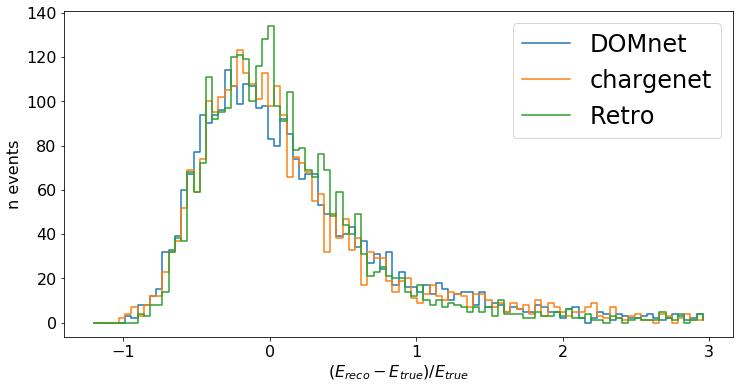

In [23]:
fig, ax = plt.subplots(1, 1, figsize=(12, 6))
hist_bins = np.linspace(-1.2, 3, 100)
for df, label in zip(all_dfs[:-1], labels):
    hist, bins = np.histogram(df['cor_e_rat'], hist_bins)
    
    ax.step(bins[:-1], hist, where='post', label=label)
    
ax.legend(fontsize=24)
ax.tick_params(labelsize=16)
ax.set_xlabel('$(E_{reco} - E_{true}) / E_{true}$', fontsize=16)
ax.set_ylabel('n events', fontsize=16)

### log energy difference by bin in true energy

For total, tracks, and cascades

In [24]:
def e_binned_plot(e_bins, hist_bins, e_var, e_var_name, 
                  plot_col, xlabel, xlim, plot_name=None,
                  figsize=(12, 12), colors=['blue', 'red'], 
                  legendfontsize=10, legendloc='best', suptitle=None):
    n_bins = len(e_bins) - 1
    
    gridsize = int(math.sqrt(n_bins))
    
    plot_vars = [df[plot_col] for df in all_dfs[:-1]]
    
    fig, axes = plt.subplots(nrows=gridsize, ncols=gridsize, figsize=figsize)
    plt.subplots_adjust(hspace=0.3)
    
    i = 0
    for ax, bin_limits in zip(axes.flat, zip(e_bins[:-1], e_bins[1:])):
        query = np.logical_and(e_var >= bin_limits[0], e_var < bin_limits[1])

        for var, label in zip(plot_vars, labels):
            hist, bins = np.histogram(var[query], hist_bins)

            ax.step(bins[:-1], hist, where='post', label=label)

        ax.set_title(f'{bin_limits[0]:.0f} <= {e_var_name} < {bin_limits[1]:.0f}',
                    fontsize=16)

        ax.legend(loc=legendloc, fontsize=legendfontsize)

        if i // gridsize == gridsize - 1:
            ax.set_xlabel(xlabel, fontsize=16)
        else:
            pass

        if i % gridsize == 0:
            ax.set_ylabel('n events', fontsize=16)
            
        ax.set_xlim(*xlim)

        ax.tick_params(labelsize=14)
        
        
        i += 1
    
    if suptitle is not None:
        fig.suptitle(suptitle, fontsize=16, y=0.95)
    
    if plot_name is not None:
        fig.savefig(plot_name, bbox='tight')

In [25]:
# build cascade and track log e diffs
for df in all_dfs[:-1]:    
    df['casc_log_e_diff'] = np.log10(df['cascade energy']) - \
        np.log10(good_true['cascade energy'])
        
    df['track_log_e_diff'] = np.log10(df['track energy']) - \
        np.log10(good_true['track energy'])

In [26]:
from itertools import product

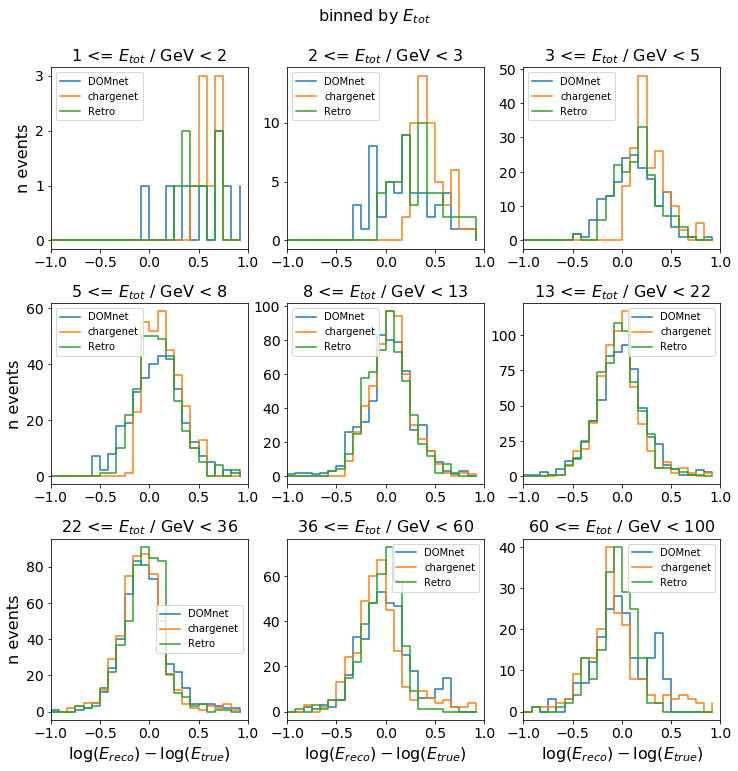

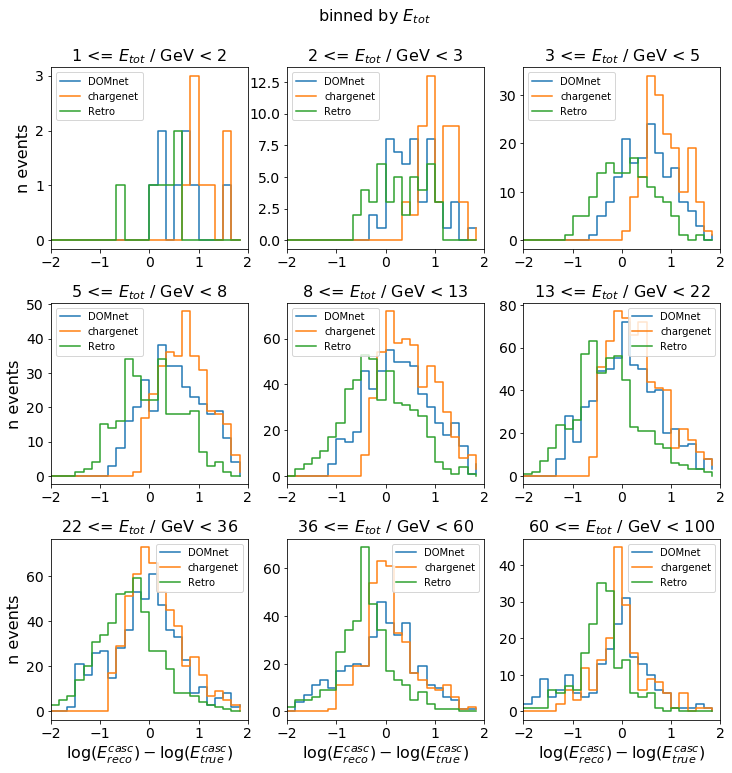

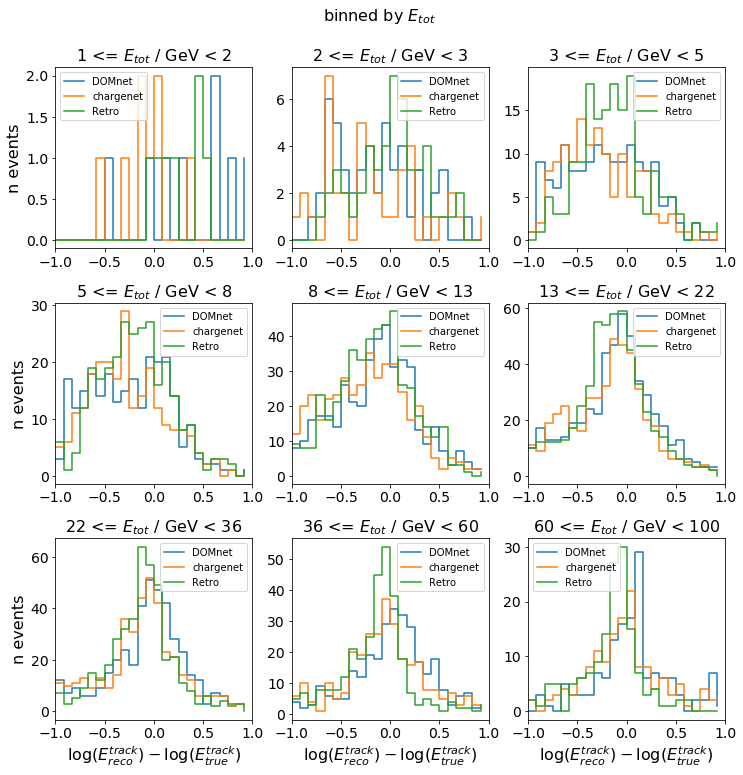

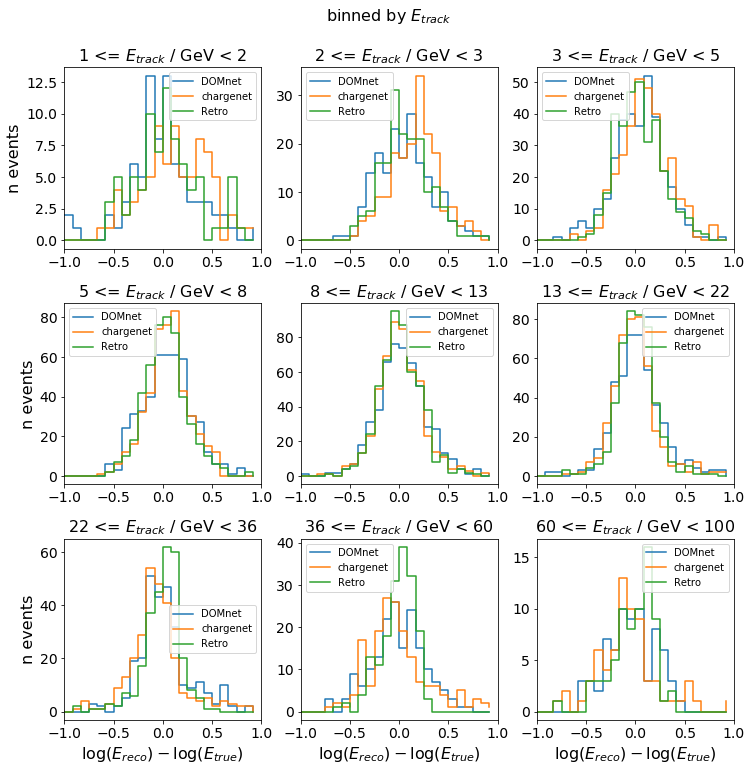

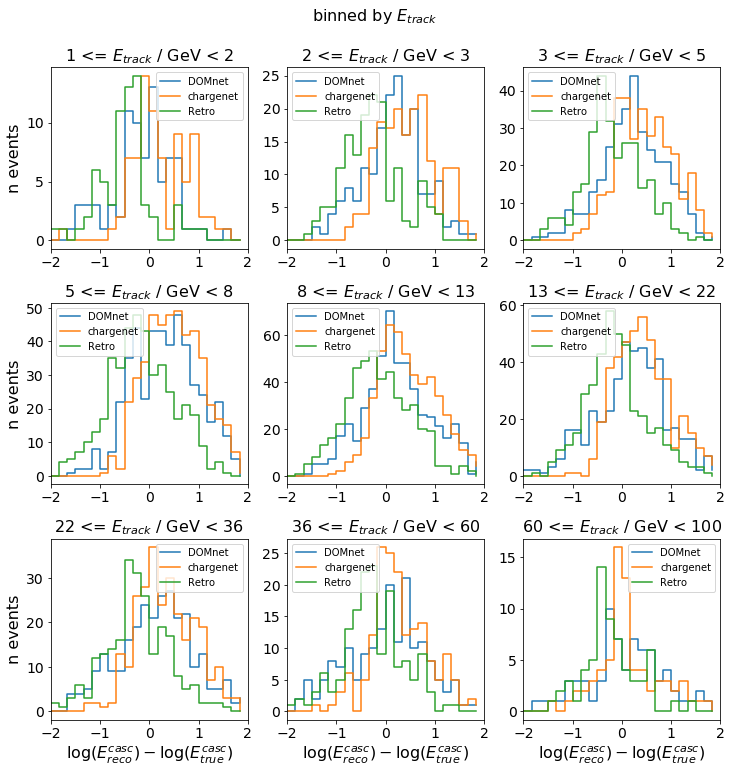

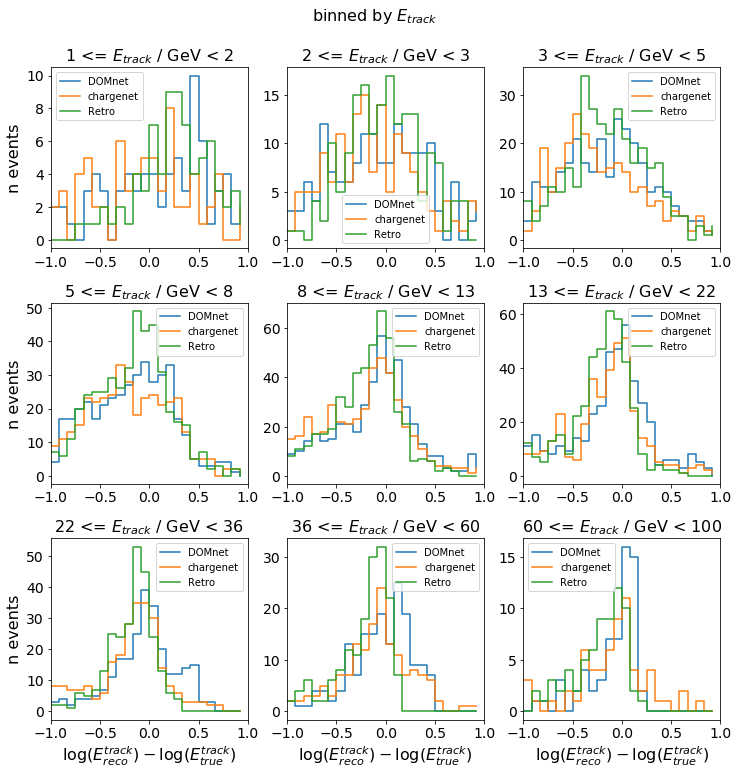

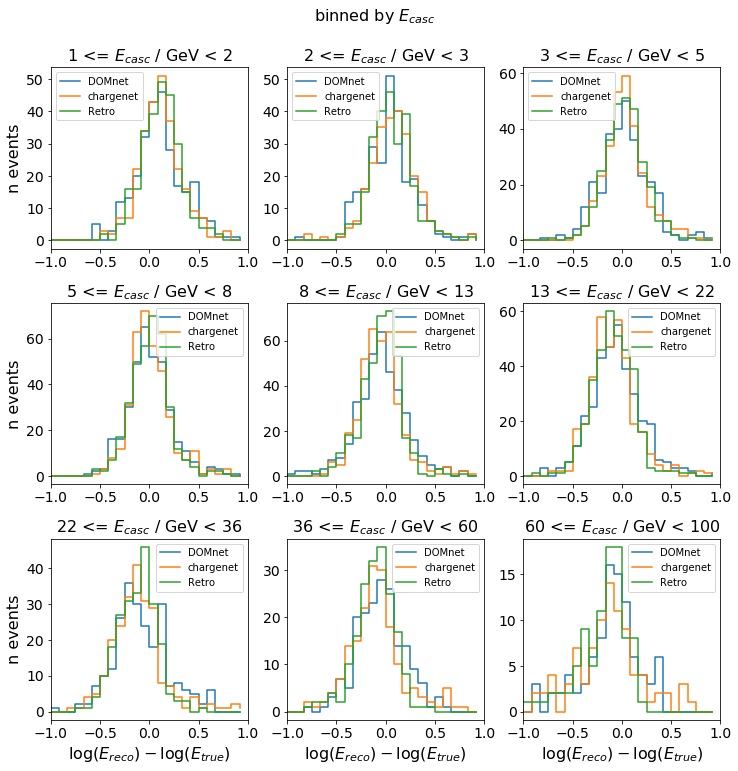

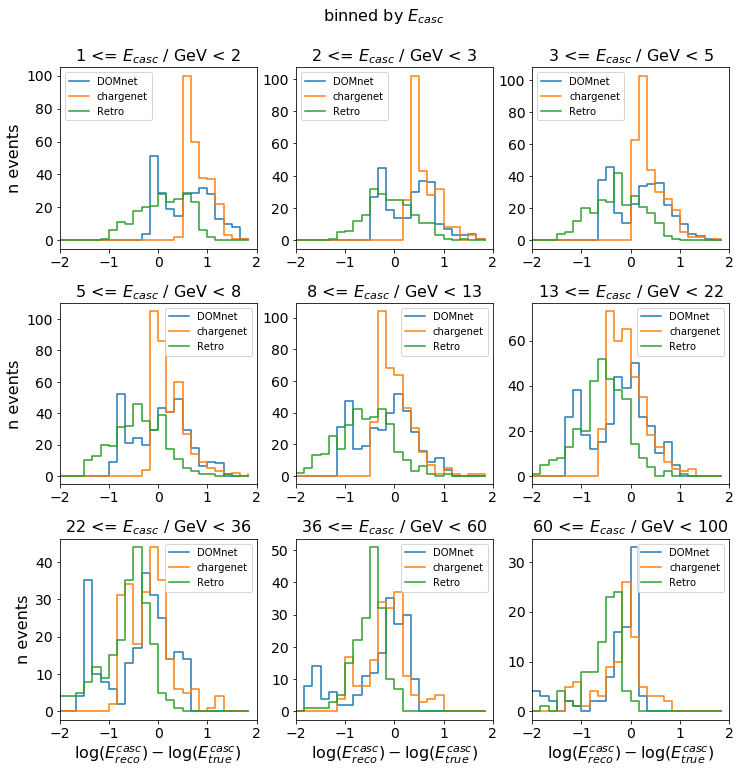

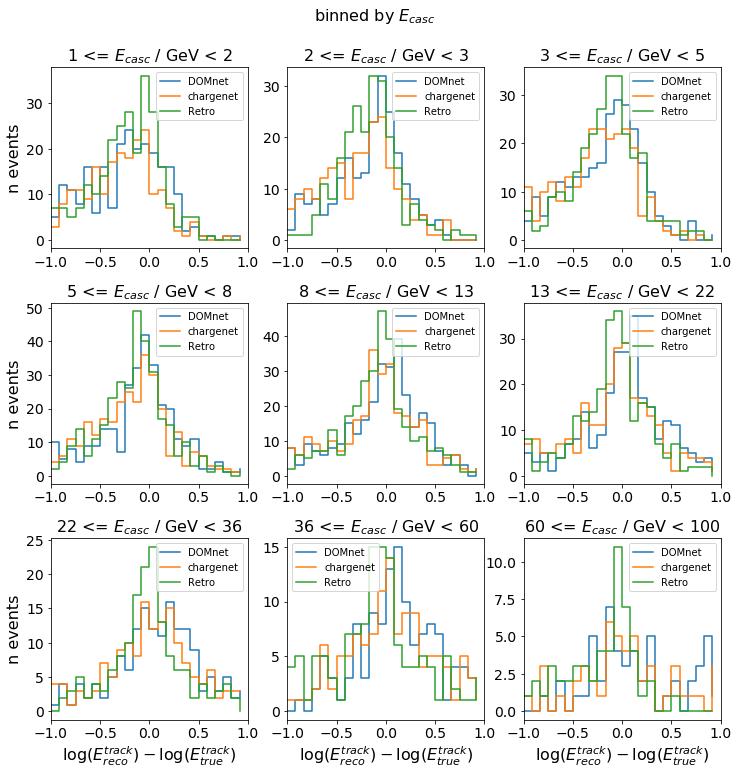

In [27]:
true_vars = ['e_tot', 'track energy', 'cascade energy']
true_names = ['$E_{{tot}}$ / GeV', '$E_{{track}}$ / GeV', '$E_{{casc}}$ / GeV']

reco_vars = ['cor_log_e_diff', 'casc_log_e_diff', 'track_log_e_diff']
reco_names = ['$\log(E_{reco}) - \log(E_{true})$',
             '$\log(E^{casc}_{reco}) - \log(E^{casc}_{true})$',
             '$\log(E^{track}_{reco}) - \log(E^{track}_{true})$']

e_bins = np.logspace(0, 2, 10)
for (true_var, true_name), (reco_var, reco_name) in product(zip(true_vars, true_names),
                                                            zip(reco_vars, reco_names)):
    xlim = (-1, 1) if not 'casc' in reco_var else (-2, 2)
    hist_bins = np.linspace(*xlim, 25)
    
    binned_by = true_name.split('/')[0].strip()
    e_binned_plot(e_bins, hist_bins, good_true[true_var], true_name,
                  reco_var, reco_name, xlim, suptitle=f'binned by {binned_by}')
    plt.show()

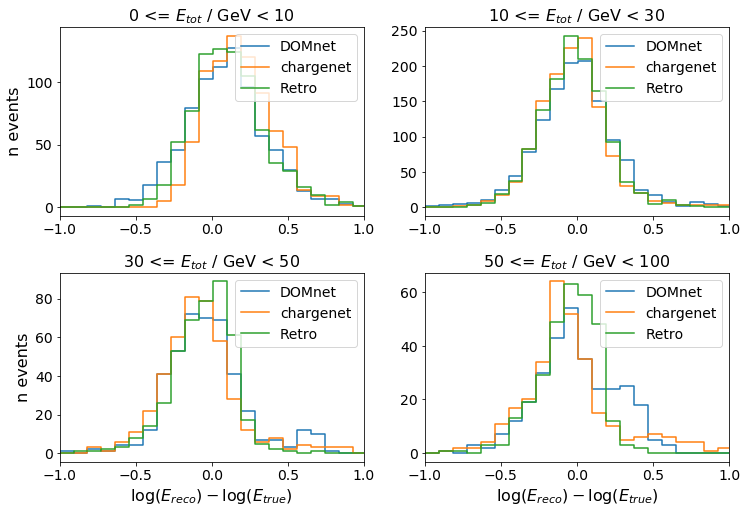

In [28]:
e_bins = [0, 10, 30, 50, 100]
hist_bins = np.linspace(-1, 1.2, 25)
e_binned_plot(e_bins, hist_bins, good_true['e_tot'], '$E_{{tot}}$ / GeV', 
              'cor_log_e_diff',
              '$\log(E_{reco}) - \log(E_{true})$',
              (-1, 1), figsize=(12, 8), colors=color_cycle, legendfontsize=14,
             legendloc='upper right') 
#plot_name='pres_plots/e_reco_domnet.pdf')

In [29]:
for df in all_dfs[:-1]:
    df['zen_diff'] = df['zenith'] - good_true['zenith']

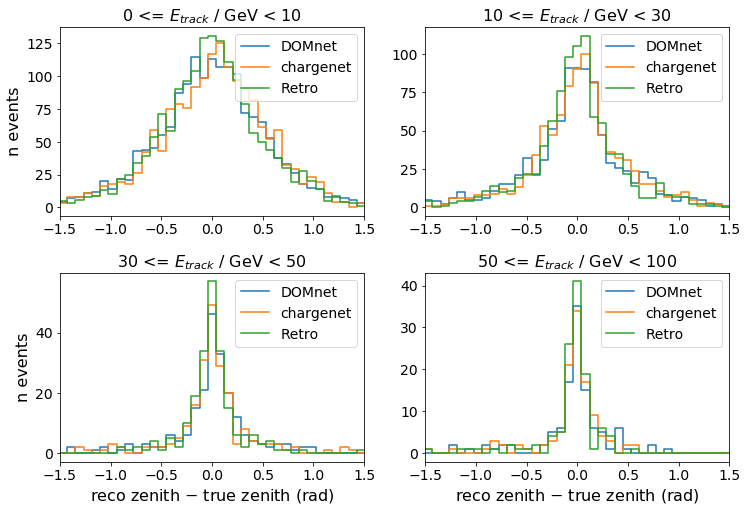

In [30]:
e_bins = [0, 10, 30, 50, 100]
hist_bins = np.linspace(-2, 2, 50)

e_binned_plot(e_bins, hist_bins, good_true['track energy'], '$E_{{track}}$ / GeV', 
              'zen_diff',
              'reco zenith $-$ true zenith (rad)',
              (-1.5, 1.5), figsize=(12,8), colors=color_cycle, legendfontsize=14, 
              legendloc='upper right') 
#               plot_name='pres_plots/zenith_reco_domnet.pdf')

### Scatter plot of best fit track energy vs best fit cascade energy

In [31]:
# to do

### Binned zenith resolution plot

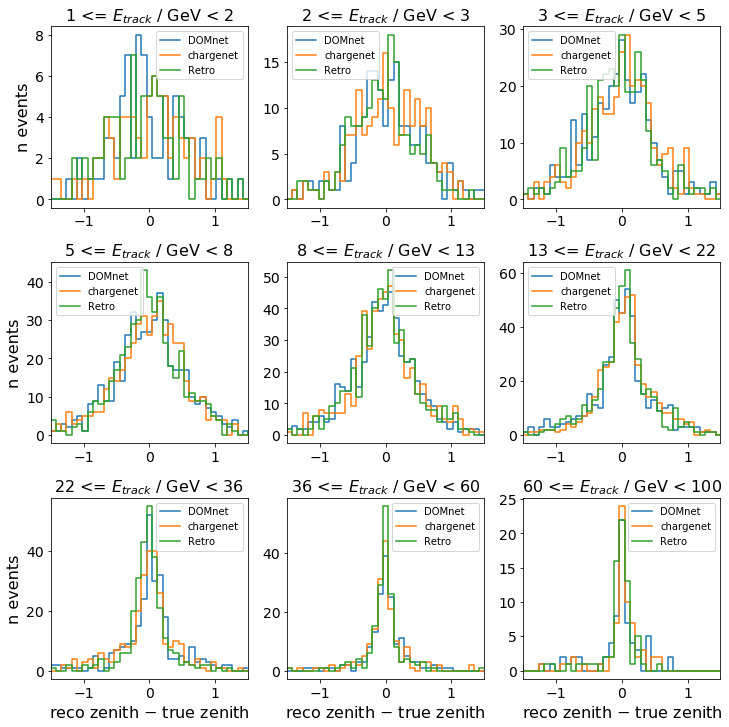

In [32]:
e_bins = np.logspace(0, 2, 10)
hist_bins = np.linspace(-2, 2, 50)

e_binned_plot(e_bins, hist_bins, good_true['track energy'], '$E_{{track}}$ / GeV', 
              'zen_diff',
              'reco zenith $-$ true zenith',
              (-1.5, 1.5))

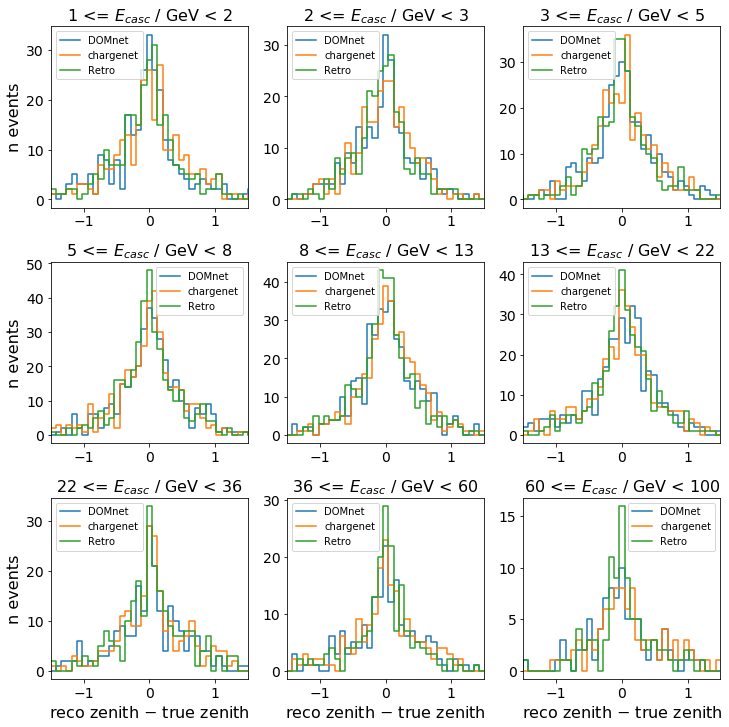

In [33]:
e_bins = np.logspace(0, 2, 10)
hist_bins = np.linspace(-2, 2, 50)

e_binned_plot(e_bins, hist_bins, good_true['cascade energy'], '$E_{{casc}}$ / GeV', 
              'zen_diff',
              'reco zenith $-$ true zenith',
              (-1.5, 1.5))

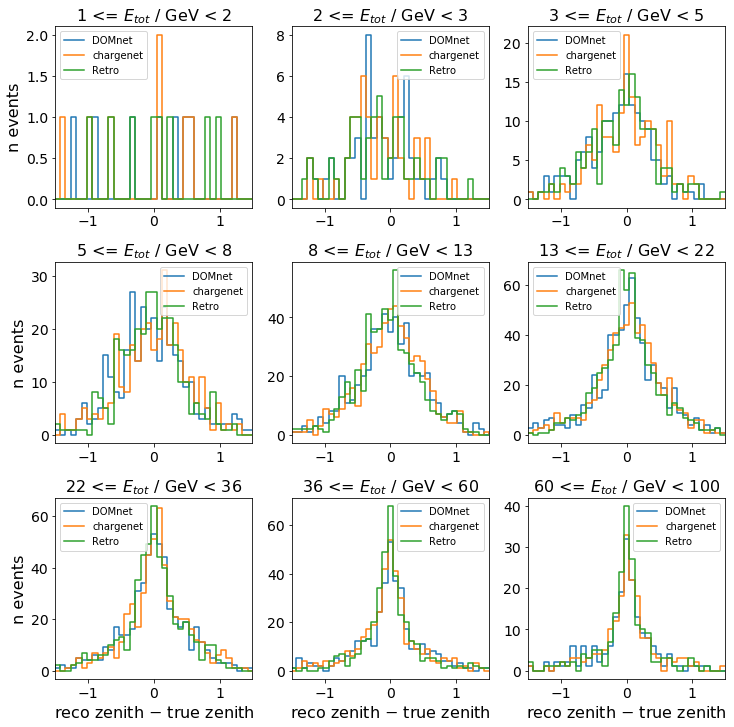

In [34]:
e_bins = np.logspace(0, 2, 10)
hist_bins = np.linspace(-2, 2, 50)

e_binned_plot(e_bins, hist_bins, good_true['e_tot'], '$E_{{tot}}$ / GeV', 
              'zen_diff',
              'reco zenith $-$ true zenith',
              (-1.5, 1.5))